# 🍷 Wine Country Prediction
This notebook aims to predict the country of origin of wines based on their description, price, variety, and review scores. We will explore both traditional NLP techniques and modern transformer-based embeddings.

## 📌 Step 1: Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sentence_transformers import SentenceTransformer
import joblib
import os

/Users/davidgelberg/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/davidgelberg/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 📌 Step 2: Load Dataset

In [2]:
# Load dataset
df = pd.read_csv("wine_quality_1000.csv")

# Display basic info
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1000 non-null   int64  
 1   country      1000 non-null   object 
 2   description  1000 non-null   object 
 3   points       1000 non-null   int64  
 4   price        1000 non-null   float64
 5   variety      1000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB
None


,Unnamed: 0,country,description,points,price,variety
0,87131,US,"Very good Dry Creek Zin, robust and dry and sp...",89,25.0,Zinfandel
1,57952,France,A very herbaceous character makes this wine se...,84,20.0,Bordeaux-style White Blend
2,96046,US,"A little simple and easy, but there's a wealth...",84,19.0,Rosé
3,31920,US,From a dry-farmed vineyard and treated to wild...,88,38.0,Petite Sirah
4,6091,US,"From a site near Annapolis, this wine shows a ...",91,62.0,Pinot Noir


## 📌 Step 3: Data Cleaning

In [3]:
# Drop unnecessary columns
df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')

# Drop duplicates
df.drop_duplicates(inplace=True)

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Fill missing values if needed (e.g., price can be filled with median)
df["price"].fillna(df["price"].median(), inplace=True)

Missing Values:
 country        0
description    0
points         0
price          0
variety        0
dtype: int64


/var/folders/xh/sglfk52531x_zd76z64fvnb80000gn/T/ipykernel_9099/1177566550.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["price"].fillna(df["price"].median(), inplace=True)


## 📌 Step 4: Data Visualization

/var/folders/xh/sglfk52531x_zd76z64fvnb80000gn/T/ipykernel_9099/528451732.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="country", palette="viridis")


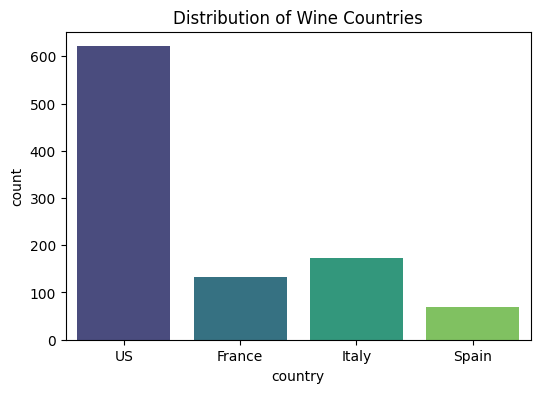

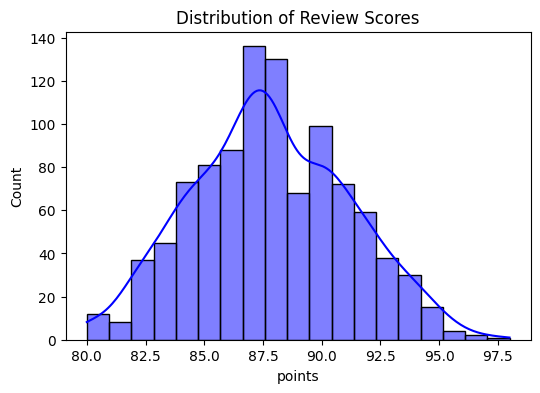

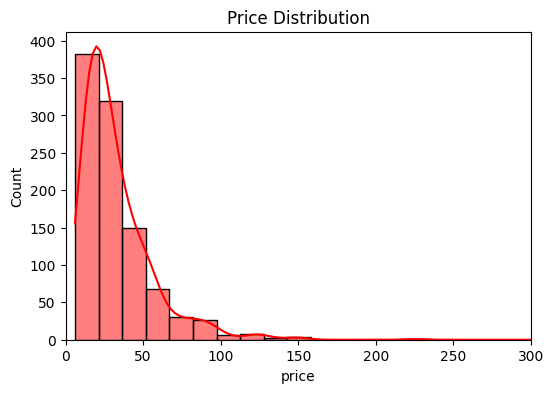

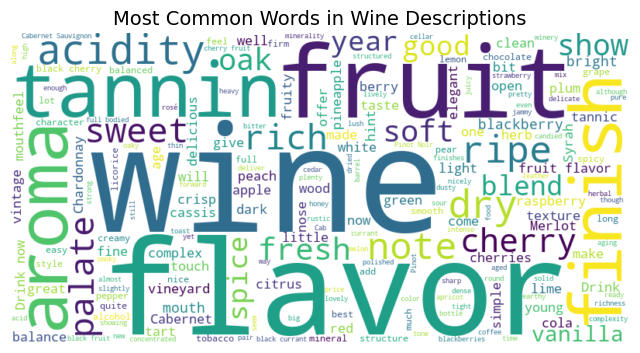

In [12]:
# Country distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="country", palette="viridis")
plt.title("Distribution of Wine Countries")
plt.show()

# Review Score Distribution
plt.figure(figsize=(6,4))
sns.histplot(df["points"], bins=19, kde=True, color="blue")
plt.title("Distribution of Review Scores")
plt.show()

# Price Distribution
plt.figure(figsize=(6,4))
sns.histplot(df["price"], bins=30, kde=True, color="red")
plt.title("Price Distribution")
plt.xlim(0, 300)
plt.show()

# Combine all descriptions into a single string
text = " ".join(df["description"].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# Display the word cloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Wine Descriptions", fontsize=14)
plt.show()

## 📌 Step 5: Feature Engineering

In [5]:
# Text Feature Engineering (TF-IDF)
tfidf = TfidfVectorizer(stop_words="english", max_features=500)
X_text = tfidf.fit_transform(df["description"]).toarray()

# Encoding categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_variety = encoder.fit_transform(df[["variety"]])

# Scaling numerical features
scaler = MinMaxScaler()
X_price_points = scaler.fit_transform(df[["price", "points"]])

# Combine features
import numpy as np
X = np.hstack([X_text, X_variety, X_price_points])
y = df["country"]


## 📌 Step 6: Train-Test Split

In [6]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## 📌 Step 7: Model Training and Evaluation

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf))


Random Forest Model Performance:
              precision    recall  f1-score   support

      France       0.92      0.44      0.60        27
       Italy       0.96      0.66      0.78        35
       Spain       1.00      0.29      0.44        14
          US       0.77      0.99      0.87       124

    accuracy                           0.81       200
   macro avg       0.91      0.59      0.67       200
weighted avg       0.84      0.81      0.79       200



In [8]:
# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data again
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)

# Decode predictions back to original labels
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)

# Evaluation
print("XGBoost Model Performance:")
print(classification_report(label_encoder.inverse_transform(y_test), y_pred_xgb_labels))

XGBoost Model Performance:
              precision    recall  f1-score   support

      France       0.85      0.63      0.72        27
       Italy       0.84      0.77      0.81        35
       Spain       0.62      0.36      0.45        14
          US       0.85      0.96      0.90       124

    accuracy                           0.84       200
   macro avg       0.79      0.68      0.72       200
weighted avg       0.83      0.84      0.83       200



## 📌 Step 8: GPT-4o

**Note:** GPT-4o was initially considered for feature extraction but was not used due to rate limits. The final model comparison includes only the implemented traditional NLP models and other techniques.

## 📌 Step 9: Save Models

In [11]:
os.makedirs("model", exist_ok=True)

# Save models
joblib.dump(rf, "model/random_forest_tfidf.pkl")
joblib.dump(xgb, "model/xgboost_tfidf.pkl")
joblib.dump(tfidf, "model/tfidf_vectorizer.pkl")
joblib.dump(encoder, "model/onehot_encoder.pkl")
joblib.dump(scaler, "model/scaler.pkl")

print("✅ Model & Preprocessing Tools Saved Successfully!")

✅ Model & Preprocessing Tools Saved Successfully!
